In [1]:
# pip install flake8 pycodestyle_magic

In [2]:
# %load_ext pycodestyle_magic

In [3]:
# %pycodestyle_on 

# Projet 5 : Segmentez la clientèle d'un site d'e-commerce

Aider les équipes d’Olist à comprendre les différents types d'utilisateurs. \
Utilisation des méthodes non supervisées pour regrouper des clients de profils similaires. \
Ces catégories pourront être utilisées par l’équipe Marketing pour mieux communiquer.

Dans ce projet, les compétences évaluées sont :

Mettre en place le modèle d'apprentissage non supervisé adapté au problème métier\
Transformer les variables pertinentes d'un modèle d'apprentissage non supervisé\
Adapter les hyperparamètres d'un algorithme non supervisé afin de l'améliorer\
Évaluer les performances d’un modèle d'apprentissage non supervisé

Démarche suivi :

    1/ Récupération et découverte des données / EDA (Exploratory Data Analysis)
    Affichage et structure des données

            1. customers 
                99441 entries / 5 columns
                0 duplicate
                100% rempli
                3/4 object 1/4 float
            2. geolocation 
                1 000 163 entries / 5 columns
                261831 duplicates
                100% rempli
                1/3 object 1/3 float 1/3 int
            3. order_items 
                112 650 entries / 7 columns
                0 duplicates
                100% rempli
                2/4 object 1/4 float 1/4 int       
            4. order_payments 
                103 886 entries / 5 columns
                0 duplicates
                100% rempli
                1/3 object 1/3 float 1/3 int              
            5. order_reviews 
                99 224 entries / 7 columns
                0 duplicates
                78% rempli
                3/4 object 1/4 int
            6. orders 
                99 441 entries / 8 columns
                0 duplicates
                99% rempli
                100% object       
            7. products 
                32 951 entries / 9 columns
                0 duplicates
                99% rempli
                1/4 object 3/4 float          
            8. sellers 
                3 095 entries / 4 columns
                0 duplicates
                100% rempli
                3/4 object 1/4 int
            9. product_category_name 
                71 entries / 2 columns
                0 duplicates
                100% rempli
                100% object


    2/ Concaténation des tables pour obtenir un dataframe 

    3/ Selection des features et analyse RFM

    4/ Comparaison Kmeans CAH DBscan
     
    5/ Best méthode : Kmeans
     
    6/ Aanlyser la stabilité dans le temps ARI

### Chargement des librairies

In [4]:
import datetime
from datetime import timedelta
from sklearn.pipeline import Pipeline
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer, \
    InterclusterDistance
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
import warnings  # supress warnings
warnings.filterwarnings('ignore')

# Fonctions diverses

In [5]:
def taux_remplissage(Food):
    nb_rows, nb_columns = Food.shape
    # Définition ligne et colonnes du dataframe Food
    nb_data = Food.count().sum()
    # Comptage du nombre de non-NaN (.count ne compte pas les NaN)
    taux_remplissage = nb_data / (nb_rows * nb_columns)
    # Calcul du taux de remplissage
    labels = ["Données remplies", "Données manquantes"]
    fig, ax = plt.subplots(figsize=(5, 5))
    plt.title("Remplissage du jeu de données", fontsize=25)
    ax.axis("equal")
    ax.pie([taux_remplissage, 1 - taux_remplissage],
           labels=labels,
           explode=(0.1, 0),
           autopct='%1.2f%%',
           shadow=True)
    plt.legend(labels, bbox_to_anchor=(1, 1), loc=2)

In [6]:
def decouverte(df):
    print('#'*75)
    print('#'*75)
    print(df.head(2))
    print('#'*45)
    print(df.info())
    print('#'*45)
    print(df.describe())
    print('#'*45)
    print((df.isnull().mean()).sort_values(ascending=[False]))
    print('#'*45)
    print(df.duplicated().sum())
    # print (msno.bar(df))
    print('#'*75)
    print('#'*75)

### Récupération et découverte des données

In [7]:
customers = pd.read_csv("/Users/gauthierrault/Desktop/P5/archive/olist_customers_dataset.csv", sep=",")

geo = pd.read_csv("/Users/gauthierrault/Desktop/P5/archive/olist_geolocation_dataset.csv", sep=",")

items = pd.read_csv("/Users/gauthierrault/Desktop/P5/archive/olist_order_items_dataset.csv", sep=",")

payments = pd.read_csv("/Users/gauthierrault/Desktop/P5/archive/olist_order_payments_dataset.csv", sep=",")

reviews = pd.read_csv("/Users/gauthierrault/Desktop/P5/archive/olist_order_reviews_dataset.csv", sep=",")

orders = pd.read_csv("/Users/gauthierrault/Desktop/P5/archive/olist_orders_dataset.csv", sep=",")

products = pd.read_csv("/Users/gauthierrault/Desktop/P5/archive/olist_products_dataset.csv", sep=",")

sellers = pd.read_csv("/Users/gauthierrault/Desktop/P5/archive/olist_sellers_dataset.csv", sep=",")

category = pd.read_csv("/Users/gauthierrault/Desktop/P5/archive/product_category_name_translation.csv", sep=",")

## Affichage et structure des données


In [8]:
decouverte(customers)

###########################################################################
###########################################################################
                        customer_id                customer_unique_id  \
0  06b8999e2fba1a1fbc88172c00ba8bc7  861eff4711a542e4b93843c6dd7febb0   
1  18955e83d337fd6b2def6b18a428ac77  290c77bc529b7ac935b93aa66c333dc3   

   customer_zip_code_prefix          customer_city customer_state  
0                     14409                 franca             SP  
1                      9790  sao bernardo do campo             SP  
#############################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   customer_id               99441 non-null  object
 1   customer_unique_id        99441 non-null  object
 2   customer_zip_code_prefix  99441 non-null  int64 


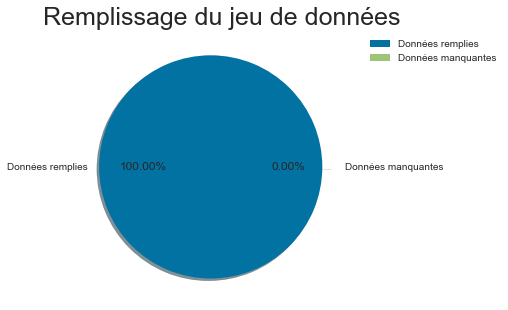

In [9]:
taux_remplissage(customers)

<AxesSubplot:ylabel='None'>

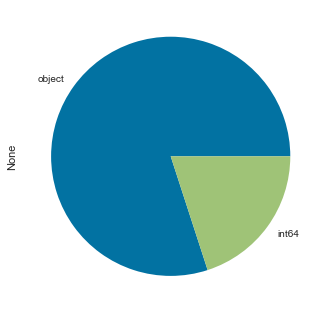

In [10]:
customers.dtypes.value_counts().plot.pie()

In [11]:
decouverte(geo)

###########################################################################
###########################################################################
   geolocation_zip_code_prefix  geolocation_lat  geolocation_lng  \
0                         1037       -23.545621       -46.639292   
1                         1046       -23.546081       -46.644820   

  geolocation_city geolocation_state  
0        sao paulo                SP  
1        sao paulo                SP  
#############################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000163 entries, 0 to 1000162
Data columns (total 5 columns):
 #   Column                       Non-Null Count    Dtype  
---  ------                       --------------    -----  
 0   geolocation_zip_code_prefix  1000163 non-null  int64  
 1   geolocation_lat              1000163 non-null  float64
 2   geolocation_lng              1000163 non-null  float64
 3   geolocation_city             1000163 non-null  object 
 4   geo

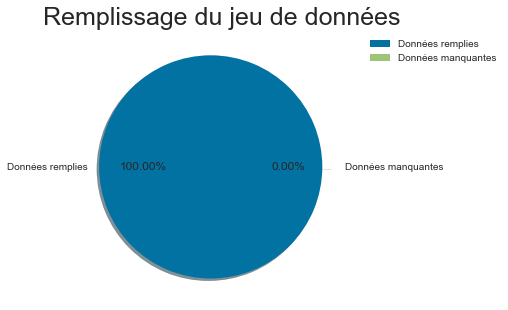

In [12]:
taux_remplissage(geo)

<AxesSubplot:ylabel='None'>

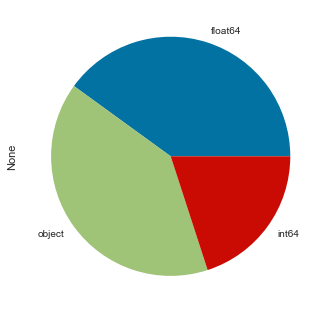

In [13]:
geo.dtypes.value_counts().plot.pie()

In [14]:
# Suppression des valeurs aberrantes
# Le point le plus au nord du Brésil est à 5 degrés 16′ 27,8″ de latitude N
geo = geo[geo.geolocation_lat <= 5.27438888]

# Le point le plus à l'ouest est à 73 degrés, 58′ 58.19″W Long
geo = geo[geo.geolocation_lng >= -73.98283055]
# Le point le plus au sud est à33 deg, 45′ 04.21″ S Latitude
geo = geo[geo.geolocation_lat >= -33.75116944]
# Le point le plus à l'est est à 4 deg, 47′ 35.33″ W Long.
geo = geo[geo.geolocation_lng <= -34.79314722]

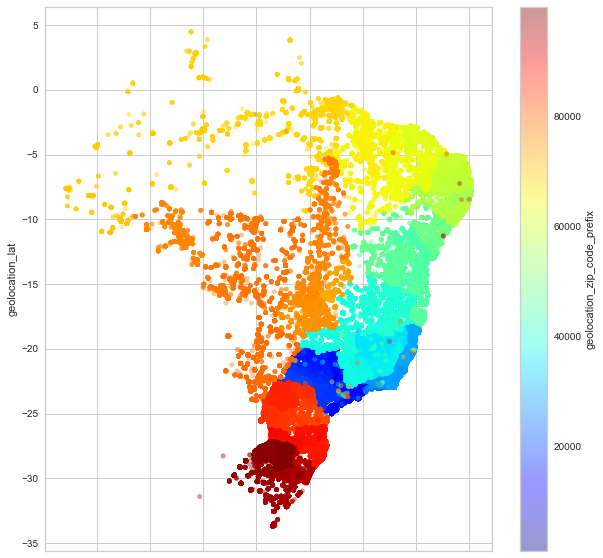

In [15]:
# Affichage graphique des zip_code_prefix,
# des latitudes et longitudes associées
geo.plot(kind="scatter", x="geolocation_lng", y="geolocation_lat",
         alpha=0.4, c="geolocation_zip_code_prefix",
         cmap=plt.get_cmap("jet"), colorbar=True, figsize=(10, 10))
plt.show()

In [16]:
decouverte(items)

###########################################################################
###########################################################################
                           order_id  order_item_id  \
0  00010242fe8c5a6d1ba2dd792cb16214              1   
1  00018f77f2f0320c557190d7a144bdd3              1   

                         product_id                         seller_id  \
0  4244733e06e7ecb4970a6e2683c13e61  48436dade18ac8b2bce089ec2a041202   
1  e5f2d52b802189ee658865ca93d83a8f  dd7ddc04e1b6c2c614352b383efe2d36   

   shipping_limit_date  price  freight_value  
0  2017-09-19 09:45:35   58.9          13.29  
1  2017-05-03 11:05:13  239.9          19.93  
#############################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112650 entries, 0 to 112649
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   order_id             112650 non-null  object 
 1   order_item

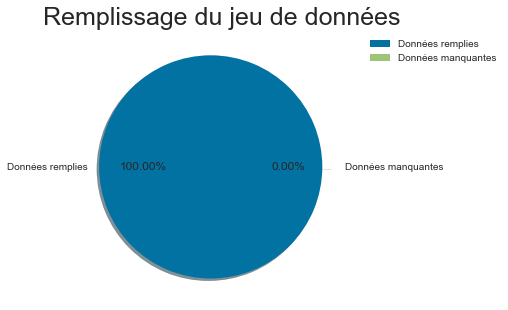

In [17]:
taux_remplissage(items)

<AxesSubplot:ylabel='None'>

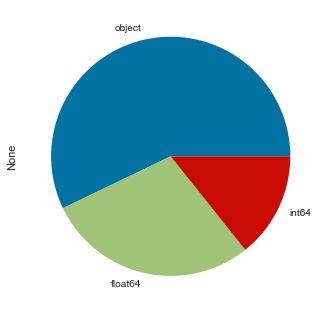

In [18]:
items.dtypes.value_counts().plot.pie()

In [19]:
decouverte(payments)

###########################################################################
###########################################################################
                           order_id  payment_sequential payment_type  \
0  b81ef226f3fe1789b1e8b2acac839d17                   1  credit_card   
1  a9810da82917af2d9aefd1278f1dcfa0                   1  credit_card   

   payment_installments  payment_value  
0                     8          99.33  
1                     1          24.39  
#############################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103886 entries, 0 to 103885
Data columns (total 5 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   order_id              103886 non-null  object 
 1   payment_sequential    103886 non-null  int64  
 2   payment_type          103886 non-null  object 
 3   payment_installments  103886 non-null  int64  
 4   payment_value         103886 non-nu

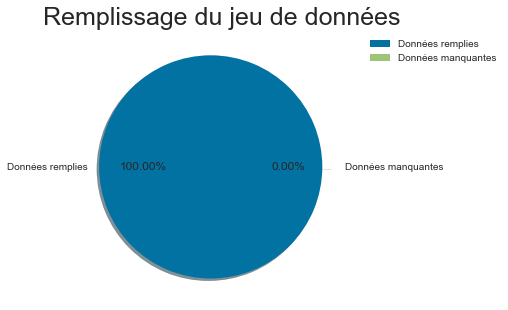

In [20]:
taux_remplissage(payments)

<AxesSubplot:ylabel='None'>

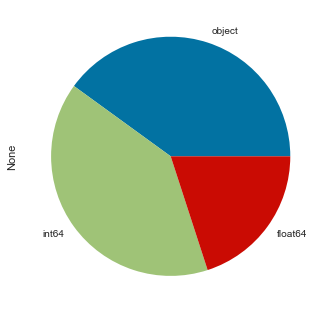

In [21]:
payments.dtypes.value_counts().plot.pie()

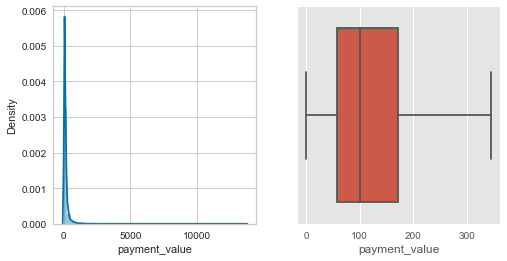

In [22]:
fig = plt.figure(1, figsize=(8, 4))
# Histogramme de "payment_value"
plt.subplot(1, 2, 1)
sns.distplot(payments["payment_value"])
plt.style.use('ggplot')

# Boxplot de "payment_value"
plt.subplot(1, 2, 2)
sns.boxplot(payments["payment_value"], showfliers=False)
plt.show()

In [23]:
payments["payment_type"].value_counts()

credit_card    76795
boleto         19784
voucher         5775
debit_card      1529
not_defined        3
Name: payment_type, dtype: int64

In [24]:
# On supprime les paiements de type "not_defined"
payment_type = ["credit_card", "boleto", "voucher", "debit_card"]
payments = payments[payments["payment_type"].isin(payment_type)]

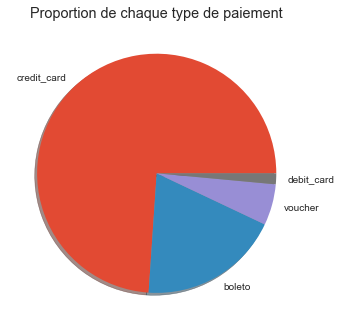

In [25]:
# Pieplot des différents moyens de paiements
plt.title("Proportion de chaque type de paiement")
fig = plt.figure(1, figsize=(8, 8))
plt.pie(payments["payment_type"].value_counts(),
        labels=payments["payment_type"].unique(), shadow=True)
plt.show()

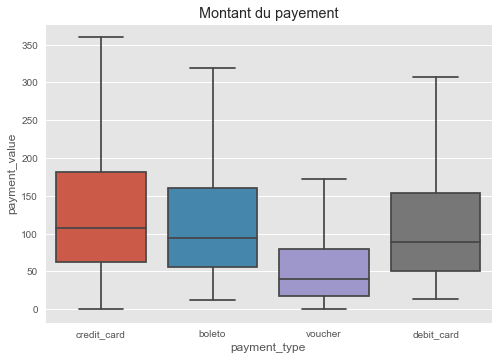

In [26]:
# Boxplot pour chaque type de paiement
plt.title("Montant du payement")
sns.boxplot(data=payments, y="payment_value",
            x="payment_type", showfliers=False)
plt.show()

In [27]:
decouverte(reviews)

###########################################################################
###########################################################################
                          review_id                          order_id  \
0  7bc2406110b926393aa56f80a40eba40  73fc7af87114b39712e6da79b0a377eb   
1  80e641a11e56f04c1ad469d5645fdfde  a548910a1c6147796b98fdf73dbeba33   

   review_score review_comment_title review_comment_message  \
0             4                  NaN                    NaN   
1             5                  NaN                    NaN   

  review_creation_date review_answer_timestamp  
0  2018-01-18 00:00:00     2018-01-18 21:46:59  
1  2018-03-10 00:00:00     2018-03-11 03:05:13  
#############################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                9

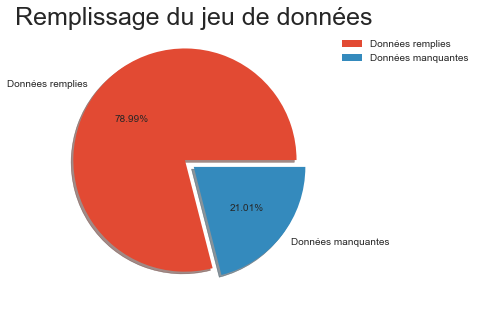

In [28]:
taux_remplissage(reviews)

<AxesSubplot:ylabel='None'>

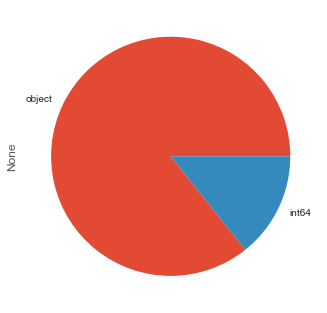

In [29]:
reviews.dtypes.value_counts().plot.pie()

In [30]:
# Conversion des données dates en datetime
review_answer_timestamp = pd.to_datetime(reviews["review_answer_timestamp"])
review_creation_date = pd.to_datetime(reviews["review_creation_date"])
# Délai d'évaluation des produits
review_answer = review_answer_timestamp - review_creation_date
# Converti en secondes
review_answer = review_answer.dt.total_seconds()/(3600*24)
reviews["Delay_to_answer"] = review_answer

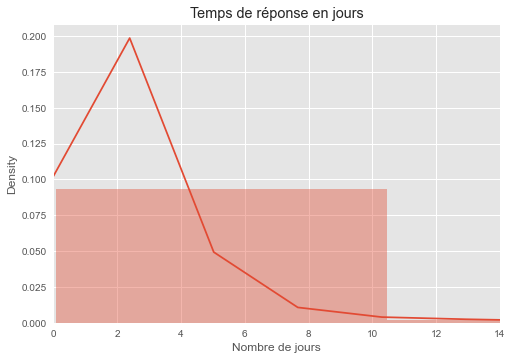

In [31]:
# Histogramme du délai d'évaluation des produits
sns.distplot(review_answer, label="Answer Time")
plt.xlim([0, 14])
plt.xlabel("Nombre de jours")
plt.title("Temps de réponse en jours")
plt.show()

In [32]:
decouverte(orders)

###########################################################################
###########################################################################
                           order_id                       customer_id  \
0  e481f51cbdc54678b7cc49136f2d6af7  9ef432eb6251297304e76186b10a928d   
1  53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   

  order_status order_purchase_timestamp    order_approved_at  \
0    delivered      2017-10-02 10:56:33  2017-10-02 11:07:15   
1    delivered      2018-07-24 20:41:37  2018-07-26 03:24:27   

  order_delivered_carrier_date order_delivered_customer_date  \
0          2017-10-04 19:55:00           2017-10-10 21:25:13   
1          2018-07-26 14:31:00           2018-08-07 15:27:45   

  order_estimated_delivery_date  
0           2017-10-18 00:00:00  
1           2018-08-13 00:00:00  
#############################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99441 entries, 0 to 99440
Data columns (tota

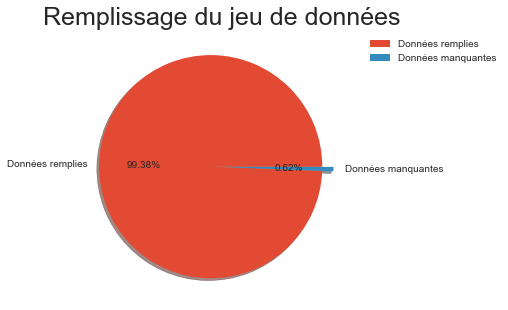

In [33]:
taux_remplissage(orders)

<AxesSubplot:ylabel='None'>

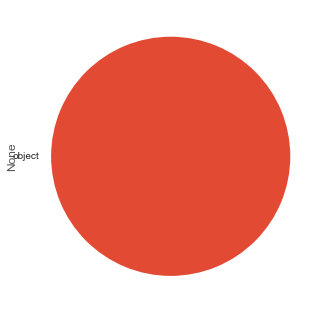

In [34]:
orders.dtypes.value_counts().plot.pie()

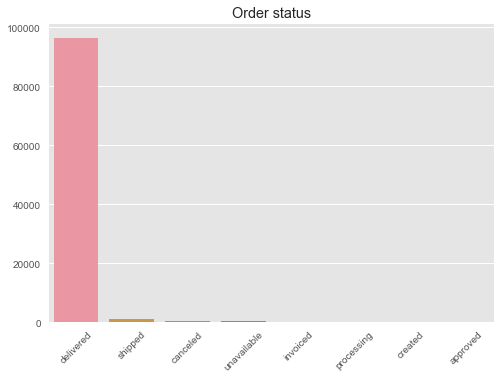

In [35]:
# Nombre de commandes par statuts d'achats
order_status = orders["order_status"].value_counts()
sns.barplot(x=order_status.index, y=order_status.values)
plt.title("Order status")
plt.xticks(rotation=45)
plt.show()

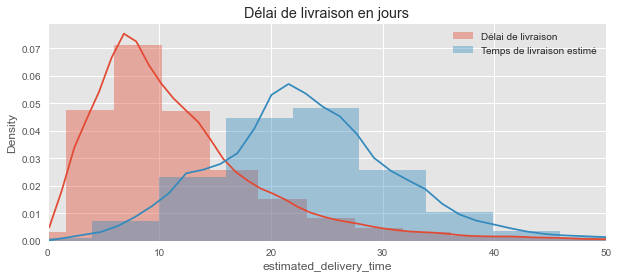

In [36]:
# Conversion des données dates en datetime
orders['order_approved_at'] = pd.to_datetime(
    orders['order_approved_at'])
orders['order_estimated_delivery_date'] = pd.to_datetime(
    orders['order_estimated_delivery_date'])
orders['order_delivered_customer_date'] = pd.to_datetime(
    orders['order_delivered_customer_date'])

# Calculate differences in hours
orders['delivery_time'] = orders['order_delivered_customer_date'] \
                          - orders['order_approved_at']
orders['delivery_time'] = orders['delivery_time'] \
                          .dt.total_seconds() / 86400

orders['estimated_delivery_time'] = orders['order_estimated_delivery_date'] \
                                    - orders['order_approved_at']
orders['estimated_delivery_time'] = orders['estimated_delivery_time'] \
                                    .dt.total_seconds() / 86400

# Delivery estimated time and actual delivery time
plt.figure(figsize=(10, 4))
plt.title("Délai de livraison en jours")
sns.distplot(orders['delivery_time'].dropna(), label='Délai de livraison')
sns.distplot(orders['estimated_delivery_time']
             .dropna(), label='Temps de livraison estimé')
plt.legend()
plt.xlim([0, 50])
plt.show()
# Calcul la différence de temps entre
# le délai réel de livraison et le délai estimé
orders['diff_time_delivery'] = orders['delivery_time'] \
                               - orders['estimated_delivery_time']

In [37]:
decouverte(products)

###########################################################################
###########################################################################
                         product_id product_category_name  \
0  1e9e8ef04dbcff4541ed26657ea517e5            perfumaria   
1  3aa071139cb16b67ca9e5dea641aaa2f                 artes   

   product_name_lenght  product_description_lenght  product_photos_qty  \
0                 40.0                       287.0                 1.0   
1                 44.0                       276.0                 1.0   

   product_weight_g  product_length_cm  product_height_cm  product_width_cm  
0             225.0               16.0               10.0              14.0  
1            1000.0               30.0               18.0              20.0  
#############################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32951 entries, 0 to 32950
Data columns (total 9 columns):
 #   Column                      Non-Null Count  Dtyp

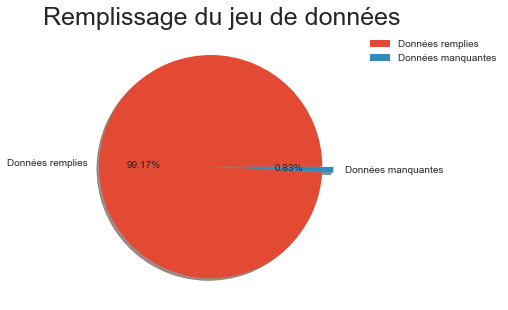

In [38]:
taux_remplissage(products)

<AxesSubplot:ylabel='None'>

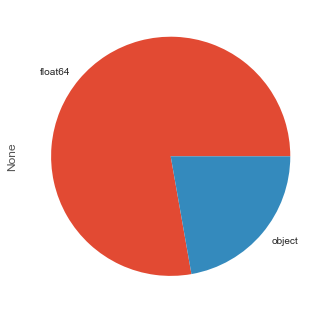

In [39]:
products.dtypes.value_counts().plot.pie()

In [40]:
decouverte(sellers)

###########################################################################
###########################################################################
                          seller_id  seller_zip_code_prefix seller_city  \
0  3442f8959a84dea7ee197c632cb2df15                   13023    campinas   
1  d1b65fc7debc3361ea86b5f14c68d2e2                   13844  mogi guacu   

  seller_state  
0           SP  
1           SP  
#############################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3095 entries, 0 to 3094
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   seller_id               3095 non-null   object
 1   seller_zip_code_prefix  3095 non-null   int64 
 2   seller_city             3095 non-null   object
 3   seller_state            3095 non-null   object
dtypes: int64(1), object(3)
memory usage: 96.8+ KB
None
#############################################
     

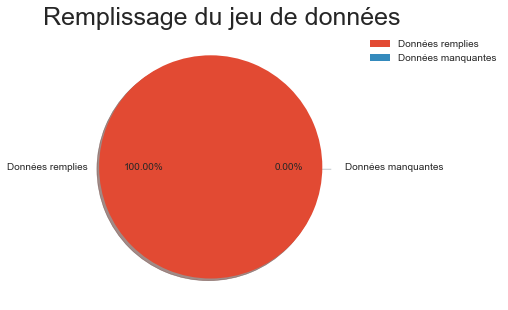

In [41]:
taux_remplissage(sellers)

<AxesSubplot:ylabel='None'>

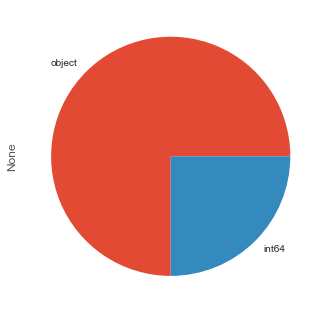

In [42]:
sellers.dtypes.value_counts().plot.pie()

In [43]:
decouverte(category)

###########################################################################
###########################################################################
    product_category_name product_category_name_english
0            beleza_saude                 health_beauty
1  informatica_acessorios         computers_accessories
#############################################
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71 entries, 0 to 70
Data columns (total 2 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   product_category_name          71 non-null     object
 1   product_category_name_english  71 non-null     object
dtypes: object(2)
memory usage: 1.2+ KB
None
#############################################
       product_category_name product_category_name_english
count                     71                            71
unique                    71                            71
top             beleza_saude

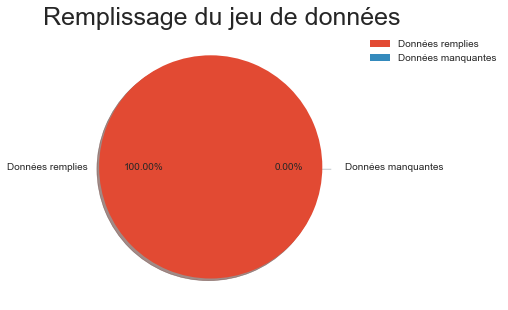

In [44]:
taux_remplissage(category)

<AxesSubplot:ylabel='None'>

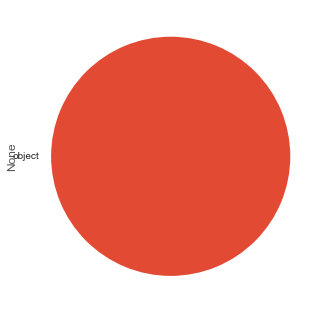

In [45]:
category.dtypes.value_counts().plot.pie()

# Concaténation des tables pour obtenir un dataframe

In [46]:
# Fusion des dataframes orders et reviews par la colonne commune 'order_id'
orders = pd.merge(orders, reviews, how='left', on=['order_id', 'order_id'])
orders = pd.merge(orders, payments, how='left', on=['order_id', 'order_id'])
orders = pd.merge(orders, items, how='left', on=['order_id', 'order_id'])

In [47]:
# Fusion des dataframes orders et customers
# par la colonne commune 'customer_id'
orders = pd.merge(orders, customers, how="left",
                  on=["customer_id", "customer_id"])

In [48]:
# Fusion des orders et des produts par la colonne 'product_id'
commande = pd.merge(orders, products, how='left', on=["product_id", 'product_id'])

In [49]:
# Ajout des catégories à l'ensemble des achats
commande = pd.merge(commande, category, how='left', on=["product_category_name", "product_category_name"])
# Suppresion de la colonne 'product_category_name'
commande.drop(columns='product_category_name', inplace=True)

In [51]:
# Renommage de certaines variables
commande.rename(columns={"geolocation_lat": "customer_lat",
                         "geolocation_lng": "customer_lng",
                         "product_category_name_english": "product_category_name"},
                inplace=True)

Validation de complétion du dataframe

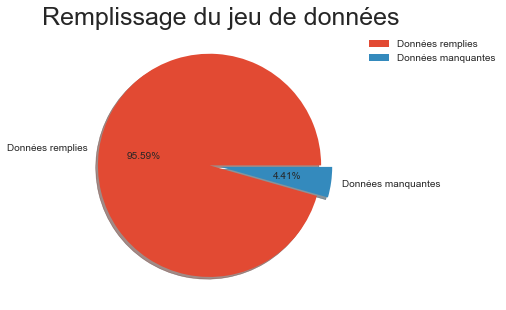

In [52]:
taux_remplissage(commande)

In [53]:
print((commande.isnull().mean()).sort_values(ascending=[False]))

review_comment_title             0.882586
review_comment_message           0.578280
diff_time_delivery               0.028839
delivery_time                    0.028839
order_delivered_customer_date    0.028713
product_category_name            0.021546
product_name_lenght              0.021336
product_description_lenght       0.021336
product_photos_qty               0.021336
order_delivered_carrier_date     0.017508
review_creation_date             0.008368
Delay_to_answer                  0.008368
review_answer_timestamp          0.008368
review_score                     0.008368
review_id                        0.008368
product_width_cm                 0.007159
product_length_cm                0.007159
product_weight_g                 0.007159
product_height_cm                0.007159
freight_value                    0.006992
order_item_id                    0.006992
product_id                       0.006992
seller_id                        0.006992
shipping_limit_date              0

In [54]:
# Suppression des données renseignés <90%
cond = (commande.isna().sum(axis=0).sort_values()/len(commande)*100) < 10

cond = cond[cond]
commande = commande.loc[:, cond.index]

commande[datetime_columns] = commande[datetime_columns].astype('datetime64[ns]')

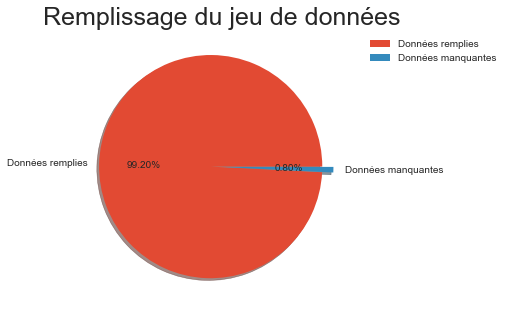

In [55]:
taux_remplissage(commande)

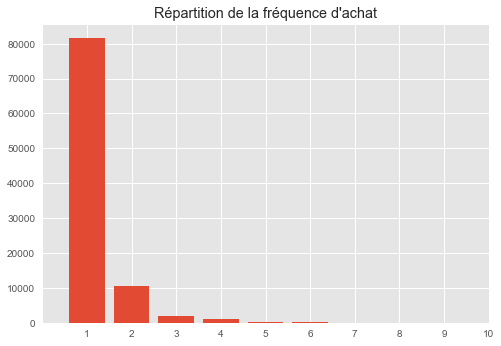

In [56]:
# Distribution of number of orders per customer

ordonnee = commande['customer_unique_id'].value_counts().unique()
plt.bar(ordonnee, [(commande['customer_unique_id'].value_counts() == a).sum() for a in ordonnee])
plt.title("Répartition de la fréquence d'achat")
plt.xticks(commande['customer_unique_id'].value_counts().unique())
plt.xlim([0, 10])
plt.show()

Complétion des valeurs manquantes par SimpleImputer

In [57]:
# Liste des colonnes num_col
num_col = list(commande.select_dtypes(include='float64').columns)
# valeurs manquantes emplacés par les moyennes des colonnes
commande[num_col] = SimpleImputer(strategy='mean').fit_transform(commande[num_col])

In [58]:
obj_col = list(commande.select_dtypes(include='object').columns)
inputer_obj = SimpleImputer(strategy='most_frequent')
commande[obj_col] = inputer_obj.fit_transform(commande[obj_col])

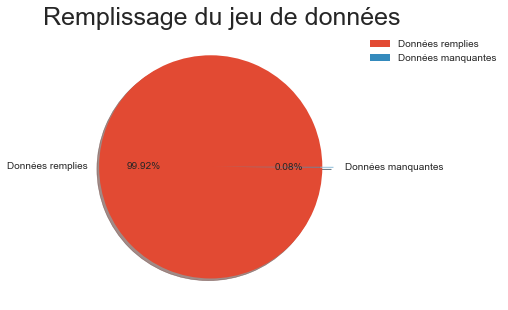

In [60]:
taux_remplissage(commande)

In [61]:
print((commande.isnull().mean()).sort_values(ascending=[False]))

order_delivered_customer_date    0.028713
order_approved_at                0.001486
order_id                         0.000000
review_score                     0.000000
product_weight_g                 0.000000
product_height_cm                0.000000
product_length_cm                0.000000
review_id                        0.000000
Delay_to_answer                  0.000000
review_answer_timestamp          0.000000
review_creation_date             0.000000
product_id                       0.000000
order_delivered_carrier_date     0.000000
product_name_lenght              0.000000
product_photos_qty               0.000000
product_description_lenght       0.000000
product_category_name            0.000000
delivery_time                    0.000000
product_width_cm                 0.000000
order_item_id                    0.000000
customer_id                      0.000000
seller_id                        0.000000
order_status                     0.000000
order_purchase_timestamp         0

In [62]:
commande = commande.dropna().reset_index()

In [63]:
commande.drop(["index"], axis=1, inplace=True)

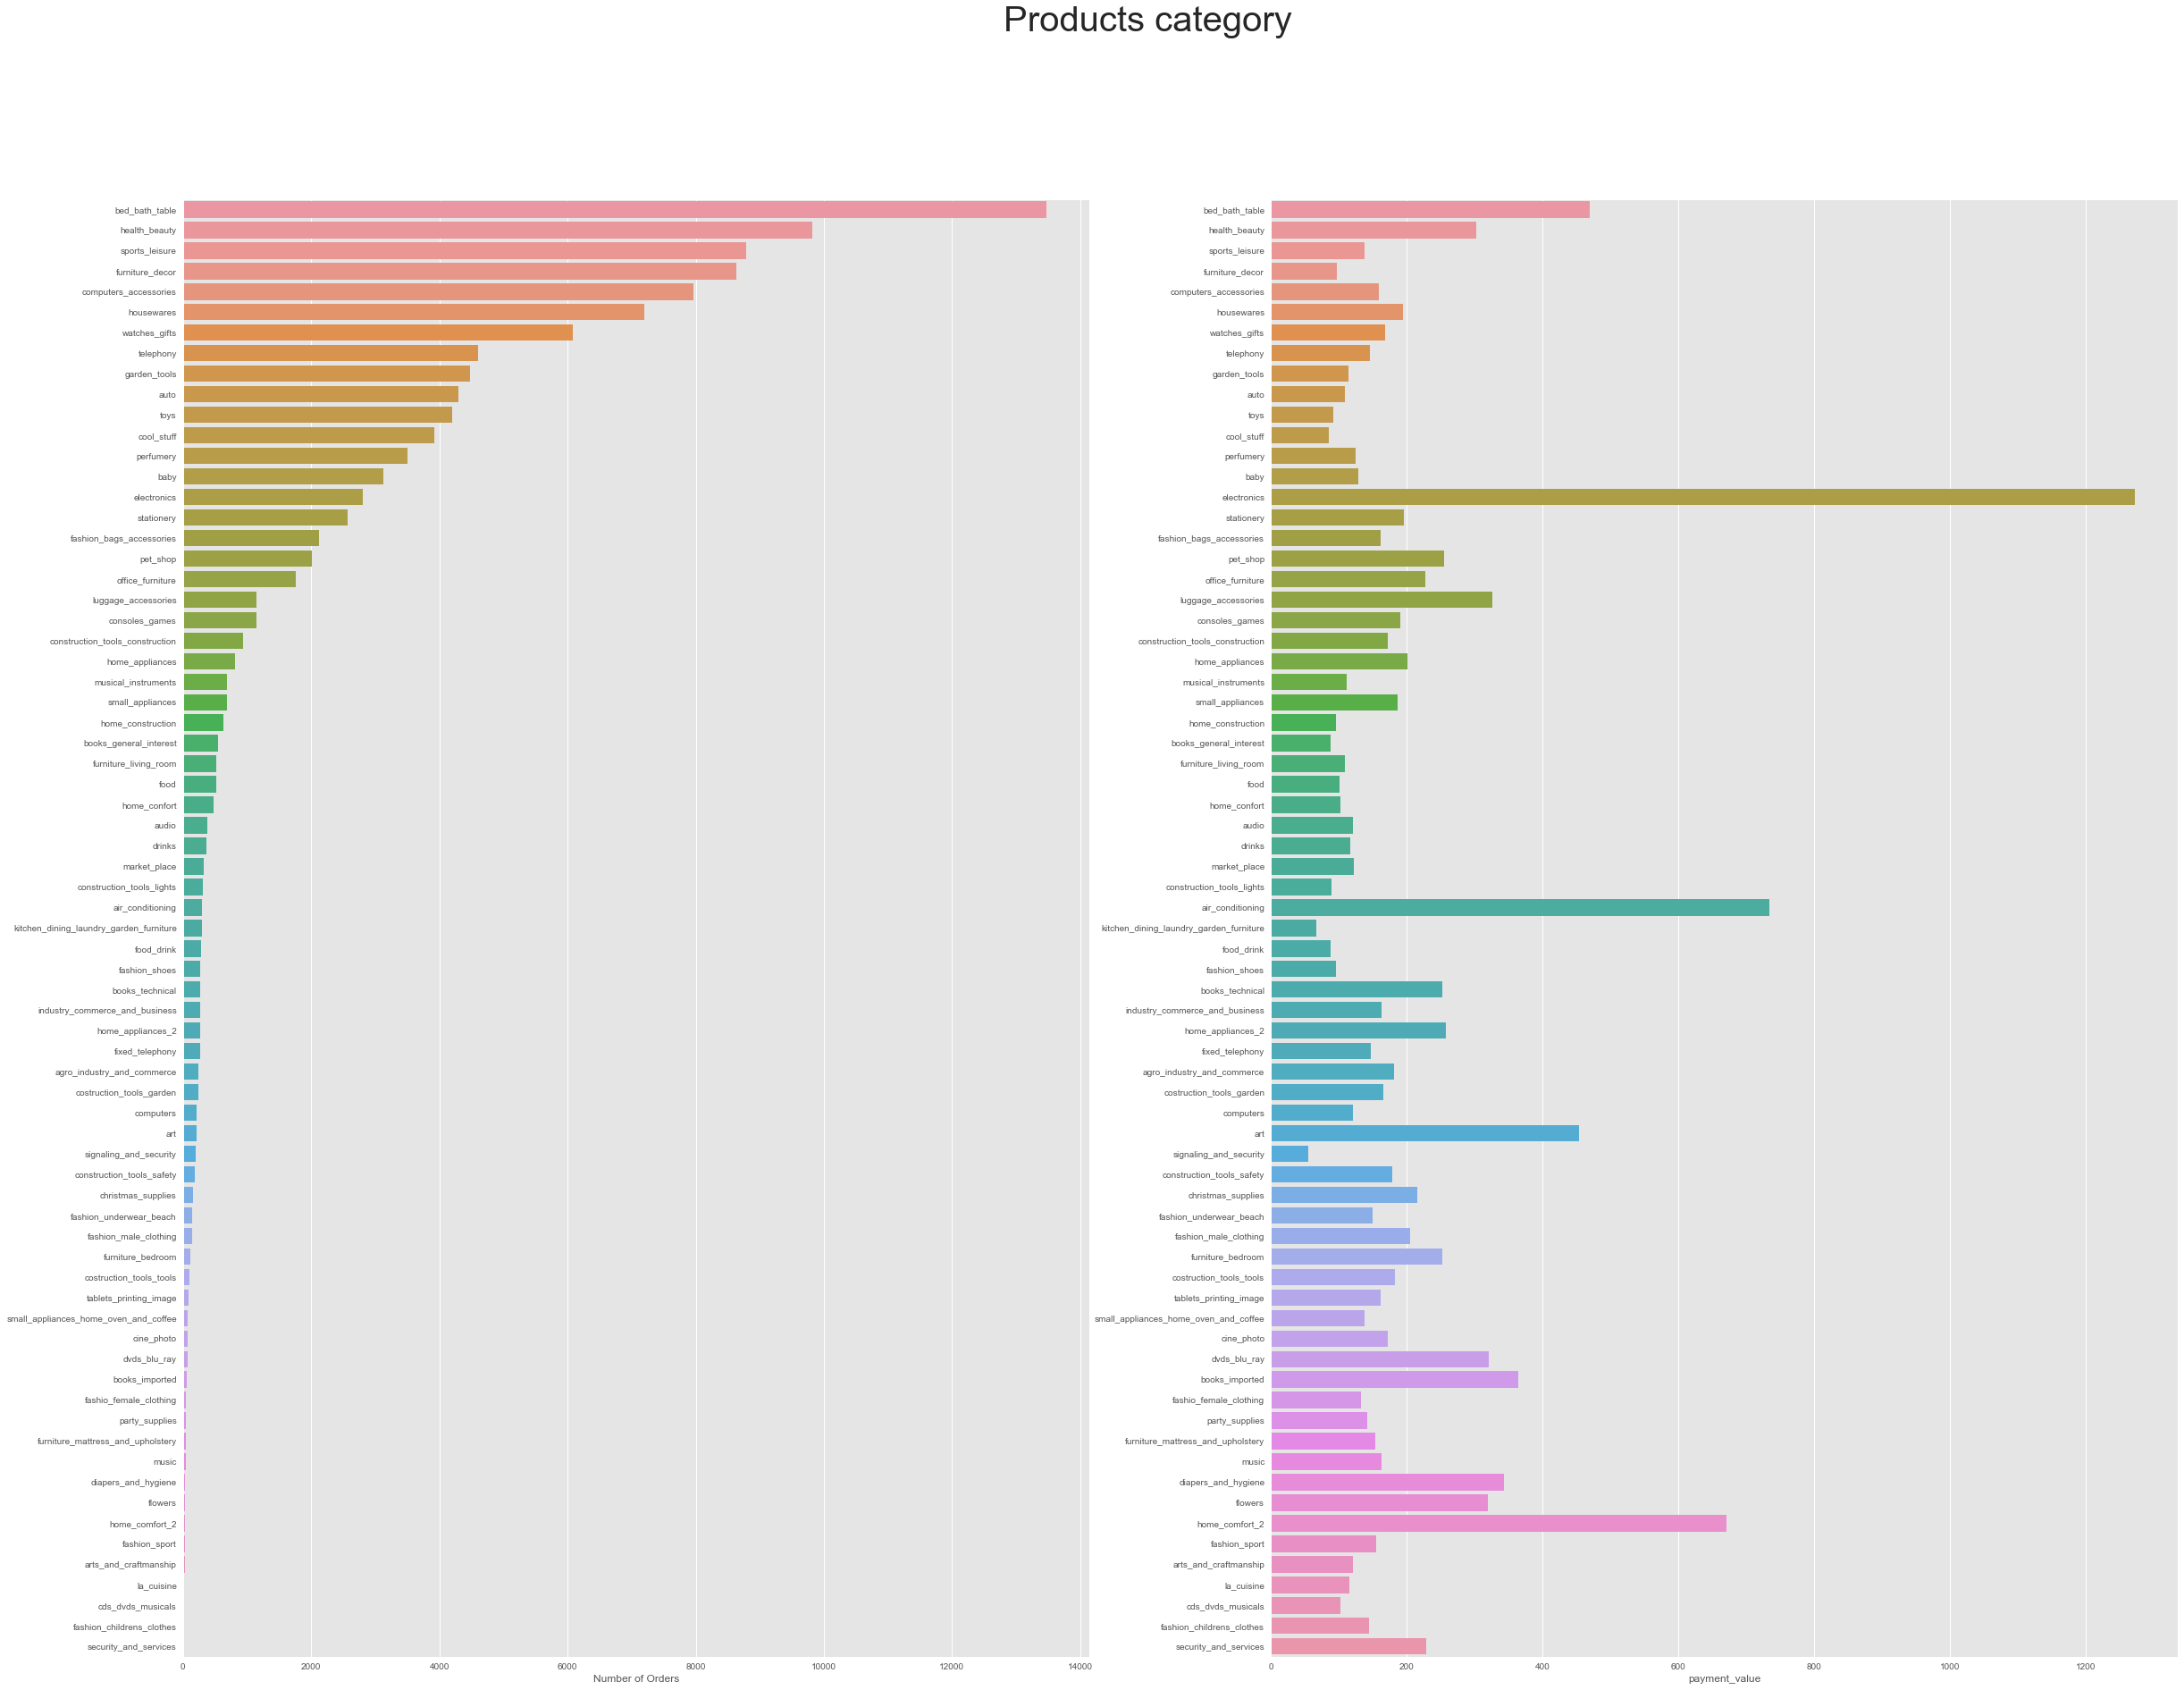

In [64]:
# Nombre de produits par catégorie de produits
products_count = commande['product_category_name'].value_counts()

# Payement moyen pour chaque catégorie de produits
products_value = commande.groupby("product_category_name")["payment_value"].mean()

# Liste des catégories
y = list(products_count.index)

fig = plt.figure(1, figsize=(40, 30))
# Nombre de produits achetés par catégorie
plt.subplot(121)
sns.barplot(products_count.values, y)
plt.xlabel("Number of Orders")

# Payement moyen par catégorie de produits
plt.subplot(122)
sns.barplot(products_value, y)
fig.suptitle("Products category", fontsize=40)
plt.show()

## Création de la segmentation RFM

In [65]:
# Transformation timestamps en datetime
time = ["order_purchase_timestamp", "order_approved_at",
        "order_delivered_carrier_date", "order_delivered_customer_date",
        "order_estimated_delivery_date"]

for cols in time:
    commande[cols] = pd.to_datetime(commande[cols], format="%Y-%m-%d", errors="ignore")

In [66]:
snapshot_date = max(commande.order_purchase_timestamp) + datetime.timedelta(days=1)

In [67]:
# Création de la segmentation RFM
rfm = commande.groupby("customer_unique_id").agg({
    "order_purchase_timestamp" : lambda x: (snapshot_date - x.max()).days,
    "order_id" : 'count',
    "payment_value" : "sum"
})
rfm.columns = ["Recency", "Frequency", "MonetaryValue"]
rfm = rfm.reset_index()

In [68]:
rfm.describe()

,Recency,Frequency,MonetaryValue
count,93343.000000,93343.000000,93343.000000
mean,237.928672,1.239589,212.976779
std,152.583723,0.849131,646.274509
min,1.000000,1.000000,9.590000
25%,114.000000,1.000000,63.830000
50%,219.000000,1.000000,113.140000
75%,346.000000,1.000000,202.645000
max,714.000000,75.000000,109312.640000


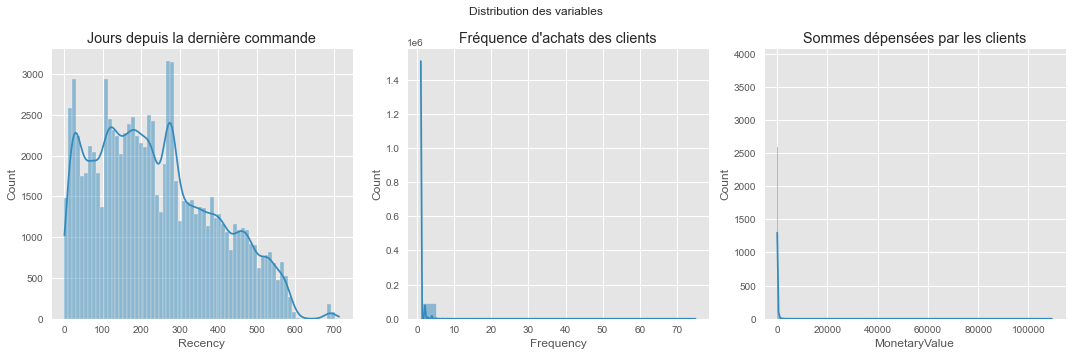

In [69]:
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Distribution des variables')

sns.histplot(ax=axes[0], x="Recency", data=rfm, kde=True)
axes[0].set_title("Jours depuis la dernière commande")

sns.histplot(ax=axes[1], x="Frequency", data=rfm, kde=True)
axes[1].set_title("Fréquence d'achats des clients")

sns.histplot(ax=axes[2], x="MonetaryValue", data=rfm, kde=True)
axes[2].set_title("Sommes dépensées par les clients")

plt.tight_layout()
plt.show()

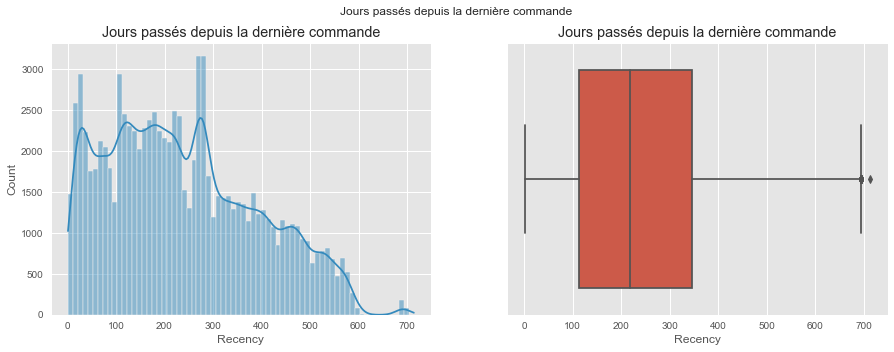

In [70]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Jours passés depuis la dernière commande')

sns.histplot(ax=axes[0], x="Recency", data=rfm, kde=True)
axes[0].set_title("Jours passés depuis la dernière commande")

sns.boxplot(ax=axes[1], x="Recency", data=rfm)
axes[1].set_title("Jours passés depuis la dernière commande")

plt.show()

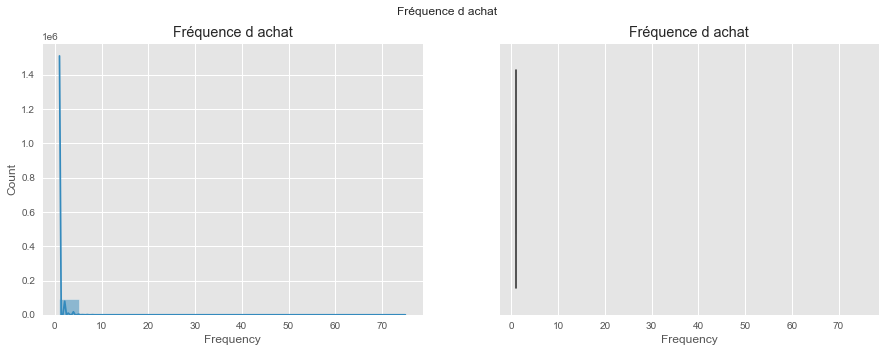

In [71]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Fréquence d achat')

sns.histplot(ax=axes[0], x="Frequency", data=rfm, kde=True)
axes[0].set_title("Fréquence d achat")

sns.boxplot(ax=axes[1], x="Frequency", data=rfm, showfliers=False)
axes[1].set_title("Fréquence d achat")

plt.show()

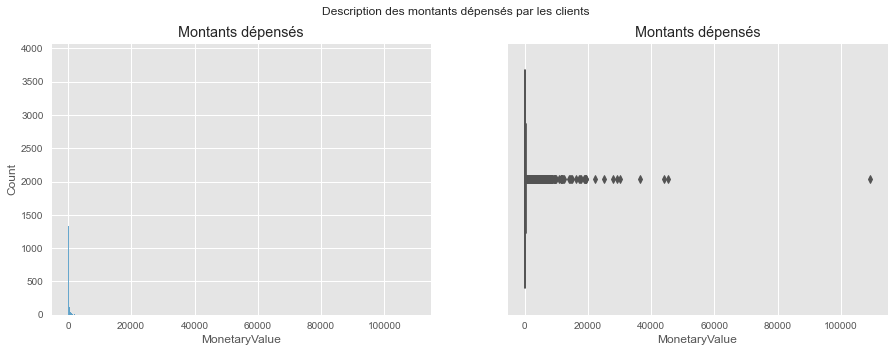

In [72]:
fig, axes = plt.subplots(1, 2, figsize=(15, 5), sharex=True)
fig.suptitle('Description des montants dépensés par les clients')

sns.histplot(ax=axes[0], x="MonetaryValue", data=rfm)
axes[0].set_title("Montants dépensés")

sns.boxplot(ax=axes[1], x="MonetaryValue", data=rfm, showfliers=True)
axes[1].set_title("Montants dépensés")

plt.show()

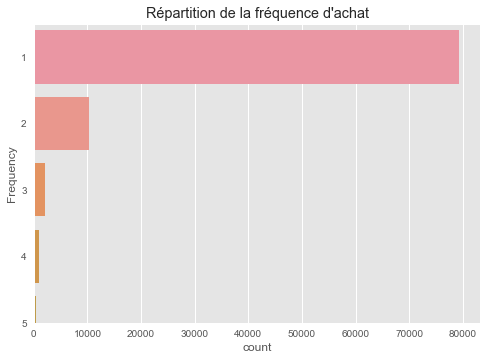

In [73]:
sns.countplot(y="Frequency", data=rfm)
plt.ylim(4)
plt.title("Répartition de la fréquence d'achat")

plt.show()

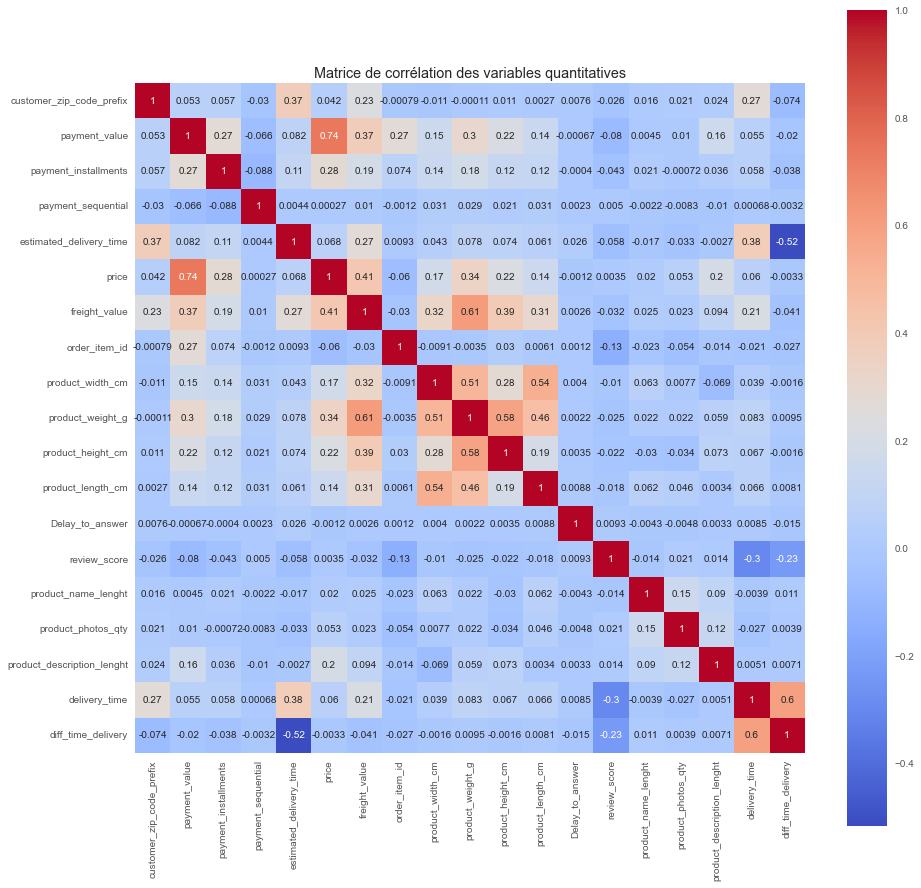

In [74]:
plt.figure(figsize=(15, 15))
sns.heatmap(commande.corr(), square=True, annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation des variables quantitatives")
plt.show()

## Ajout de variable sur la segmentation RFM

In [75]:
rfm.set_index(['customer_unique_id'], inplace=True)

In [76]:
# Creation of RFM segmentation
rfm_review = commande.groupby("customer_unique_id").agg({
    "order_purchase_timestamp" : lambda x: (snapshot_date - x.max()).days,
    "order_id" : 'count',
    "payment_value" : "sum",
    "review_score" : "mean"
})
rfm_review.columns = ["Recency", "Frequency", "MonetaryValue","Review"]
rfm_review = rfm_review.reset_index()

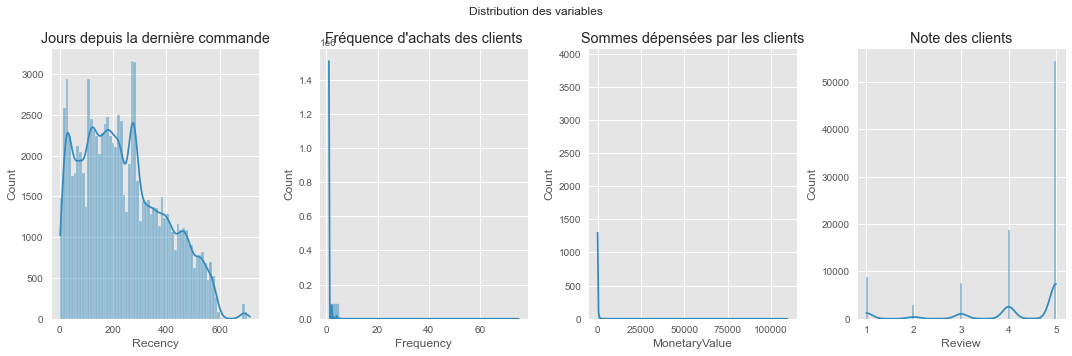

In [82]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))
fig.suptitle('Distribution des variables')

sns.histplot(ax=axes[0], x="Recency", data=rfm_review, kde=True)
axes[0].set_title("Jours depuis la dernière commande")

sns.histplot(ax=axes[1], x="Frequency", data=rfm_review, kde=True)
axes[1].set_title("Fréquence d'achats des clients")

sns.histplot(ax=axes[2], x="MonetaryValue", data=rfm_review, kde=True)
axes[2].set_title("Sommes dépensées par les clients")

sns.histplot(ax=axes[3], x="Review", data=rfm_review, kde=True)
axes[3].set_title("Note des clients")

plt.tight_layout()
plt.show()

In [77]:
rfm_review.set_index(['customer_unique_id'], inplace=True)

## Sauvegarde des fichiers CSV

In [78]:
commande.to_csv(r'/Users/gauthierrault/Desktop/P5/commande.csv')

In [79]:
rfm.to_csv(r'/Users/gauthierrault/Desktop/P5/rfm.csv')

In [80]:
rfm_review.to_csv(r'/Users/gauthierrault/Desktop/P5/rfm_review.csv')